## 1. First check if the GPU is available and running

In [1]:
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow Version:", tf.__version__)

# List available devices, filter for GPU devices
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("GPU Available:", gpu)
else:
    print("No GPU found")

TensorFlow Version: 2.10.1
GPU Available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## 2. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
#import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from google.colab.patches import cv2_imshow

## 3. Load Data and get some information about it.

In [3]:
keyfacial_df = pd.read_csv('./Emotion AI Dataset/data.csv')

In [4]:
keyfacial_df

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,67.180378,35.816373,33.239956,34.921932,59.347973,37.000904,72.667896,37.097600,39.404349,36.589944,...,60.065396,64.397610,73.248393,35.446431,74.014748,48.708626,76.760852,48.559612,77.335618,191 191 191 190 189 185 184 120 54 34 19 24 31...
2136,65.724490,36.301020,25.377551,37.311224,58.530612,37.739796,74.448980,37.525510,33.551020,38.107143,...,62.472789,66.928121,79.229046,28.015377,81.151722,48.771976,81.816774,49.287271,82.871156,19 19 19 18 13 7 3 4 3 1 3 9 11 12 12 13 10 9 ...
2137,68.430866,38.651975,28.895857,37.617027,61.659350,40.100902,75.586792,40.219182,37.665118,39.087245,...,63.289576,68.864397,77.495823,22.013981,77.368995,49.180628,79.043130,47.176739,89.544522,31 40 47 31 54 58 63 100 86 80 82 75 79 86 90 ...
2138,64.152180,30.691592,27.000898,40.868082,56.505624,34.126963,73.436776,28.556335,34.746122,40.506939,...,59.735799,73.730743,70.273886,38.777143,80.684286,58.042857,79.301429,58.611086,80.355543,7 1 5 1 3 20 12 0 5 8 6 18 13 9 8 12 12 11 4 8...


In [5]:
keyfacial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [6]:
# Check if null values exist in the dataframe
keyfacial_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [7]:
keyfacial_df['Image'].shape

(2140,)

In [8]:
keyfacial_df.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,...,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,66.221549,36.842274,29.640269,37.063815,59.272128,37.856014,73.412473,37.640110,36.603107,37.920852,...,47.952141,57.253926,63.419076,75.887660,32.967365,76.134065,48.081325,72.681125,48.149654,82.630412
std,2.087683,2.294027,2.051575,2.234334,2.005631,2.034500,2.701639,2.684162,1.822784,2.009505,...,3.276053,4.528635,3.650131,4.438565,3.595103,4.259514,2.723274,5.108675,3.032389,4.813557
min,47.835757,23.832996,18.922611,24.773072,41.779381,27.190098,52.947144,26.250023,24.112624,26.250023,...,24.472590,41.558400,43.869480,57.023258,9.778137,56.690208,32.260312,56.719043,33.047605,57.232296
25%,65.046300,35.468842,28.472224,35.818377,58.113054,36.607950,71.741978,36.102409,35.495730,36.766783,...,46.495330,54.466000,61.341291,72.874263,30.879288,73.280038,46.580004,69.271669,46.492000,79.417480
50%,66.129065,36.913319,29.655440,37.048085,59.327154,37.845220,73.240045,37.624207,36.620735,37.920336,...,47.900511,57.638582,63.199057,75.682465,33.034022,75.941985,47.939031,72.395978,47.980854,82.388899
75%,67.332093,38.286438,30.858673,38.333884,60.521492,39.195431,74.978684,39.308331,37.665280,39.143921,...,49.260657,60.303524,65.302398,78.774969,35.063575,78.884031,49.290000,75.840286,49.551936,85.697976
max,78.013082,46.132421,42.495172,45.980981,69.023030,47.190316,87.032252,49.653825,47.293746,44.887301,...,65.279654,75.992731,84.767123,94.673637,50.973348,93.443176,61.804506,93.916338,62.438095,95.808983


## 4.  Reshape Data

In [9]:
# Since values for the image are given as space separated string, separate the values using ' ' as separator.
# Then convert this into numpy array using np.fromstring and convert the obtained 1D array into 2D array of shape (96, 96)
keyfacial_df['Image'] = keyfacial_df['Image'].apply(lambda x: np.fromstring(x, dtype = int, sep = ' ').reshape(96, 96))

In [10]:
# Obtain the Shape of the image
keyfacial_df['Image'][0].shape

(96, 96)

## 5. Visualize data

C:\Users\Abdullah\AppData\Local\Temp\ipykernel_27288\2588089196.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')


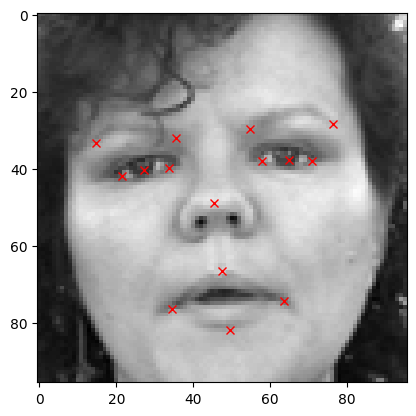

In [11]:
# Get a random image
# Need to put an indicator on each keypoint feature.These are given my keyfacial_df
# x-coordinates are even columns and y coordinates are odd columns.
# we access their value using .loc command, which get the values for coordinates of the image based on the column it is refering to.

i = np.random.randint(1, len(keyfacial_df))
plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')

C:\Users\Abdullah\AppData\Local\Temp\ipykernel_27288\2326743768.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')


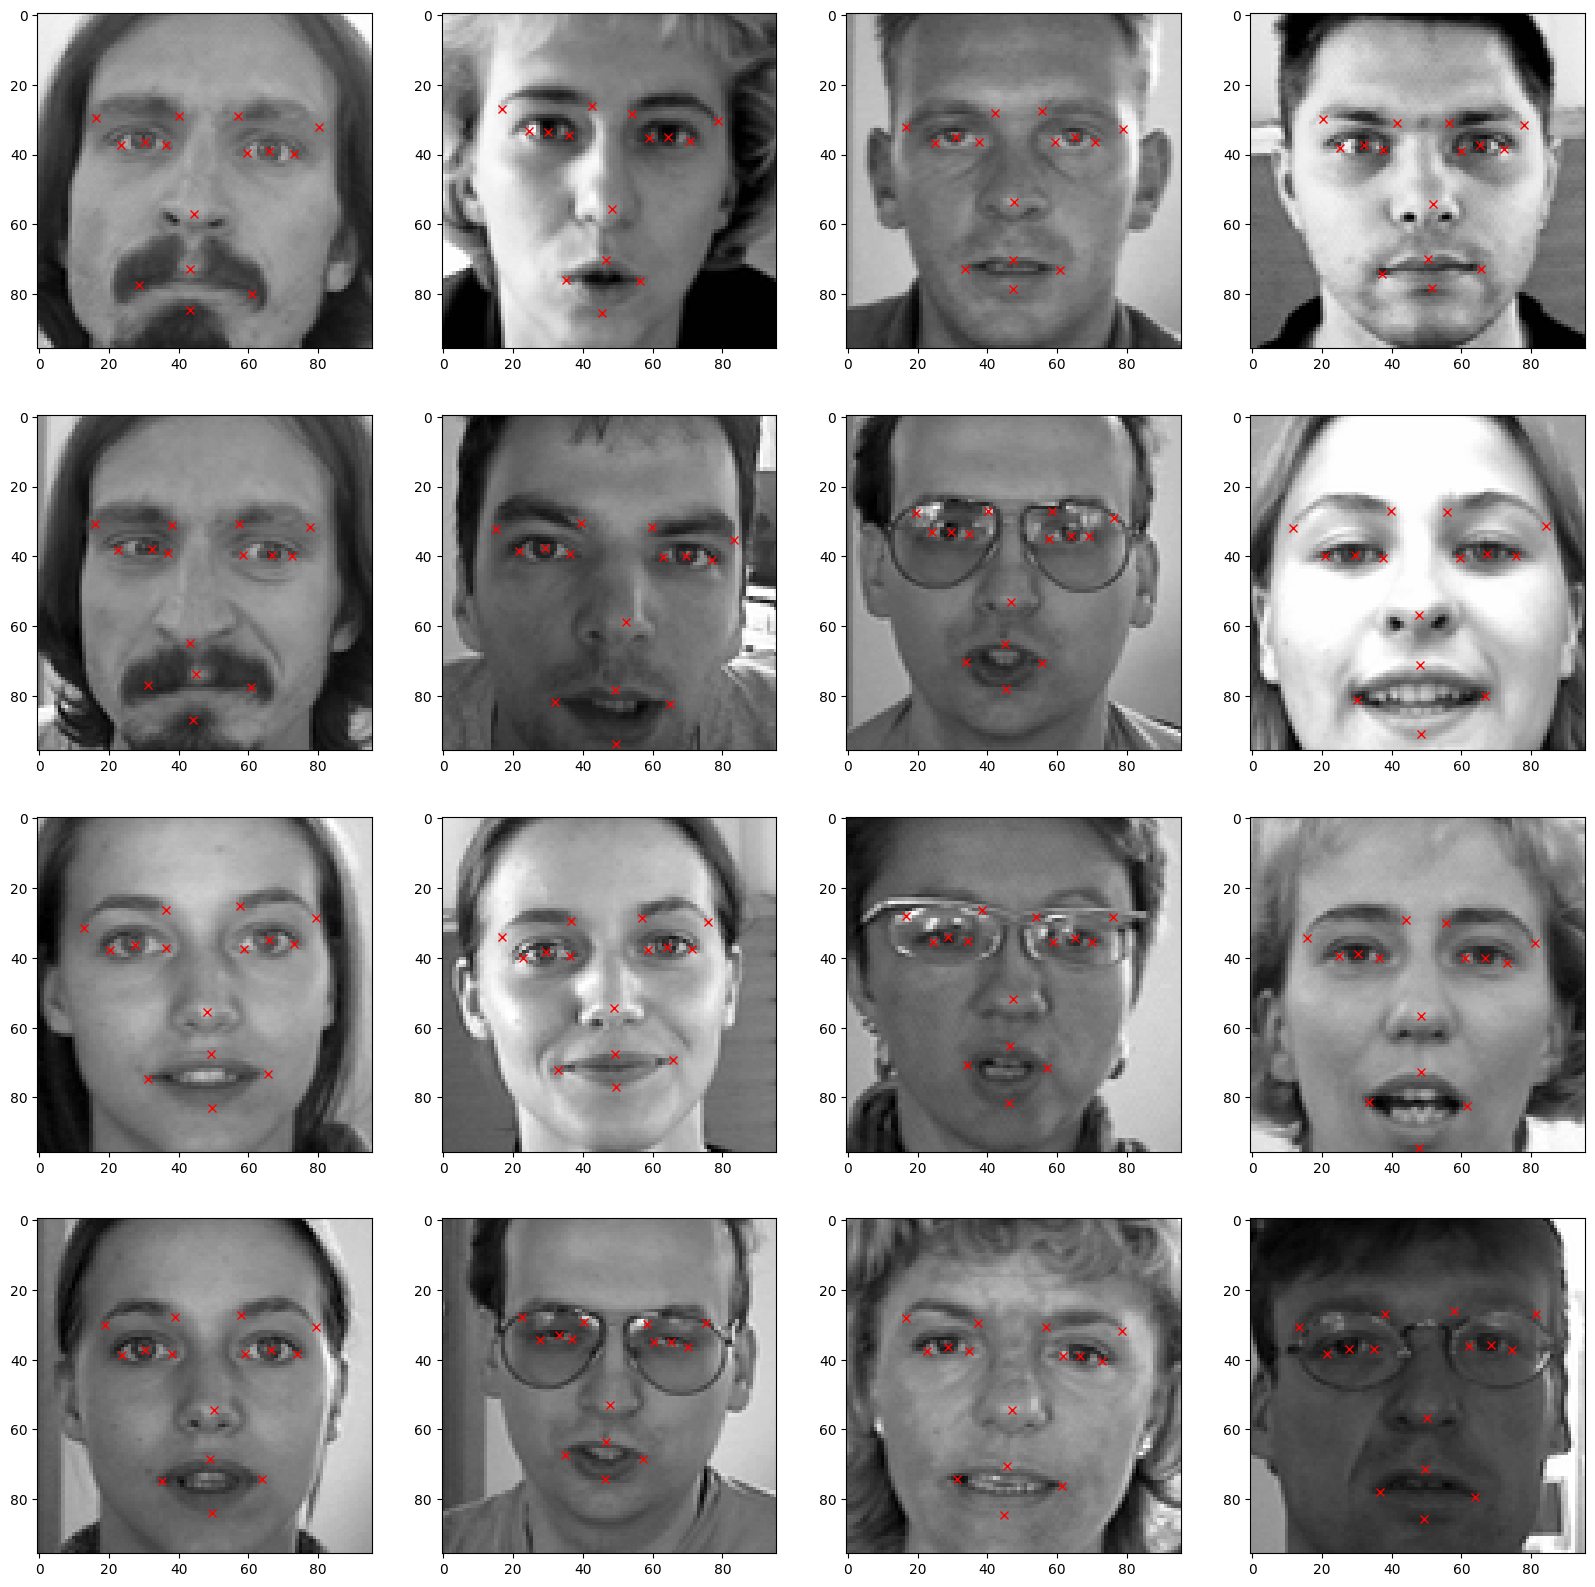

In [12]:
# Let's view more images in a grid format
#Same process but visualises more images..

fig = plt.figure(figsize=(20, 20))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)    
    image = plt.imshow(keyfacial_df['Image'][i],cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')

C:\Users\Abdullah\AppData\Local\Temp\ipykernel_27288\3552235260.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[k][j-1], keyfacial_df.loc[k][j], 'rx')


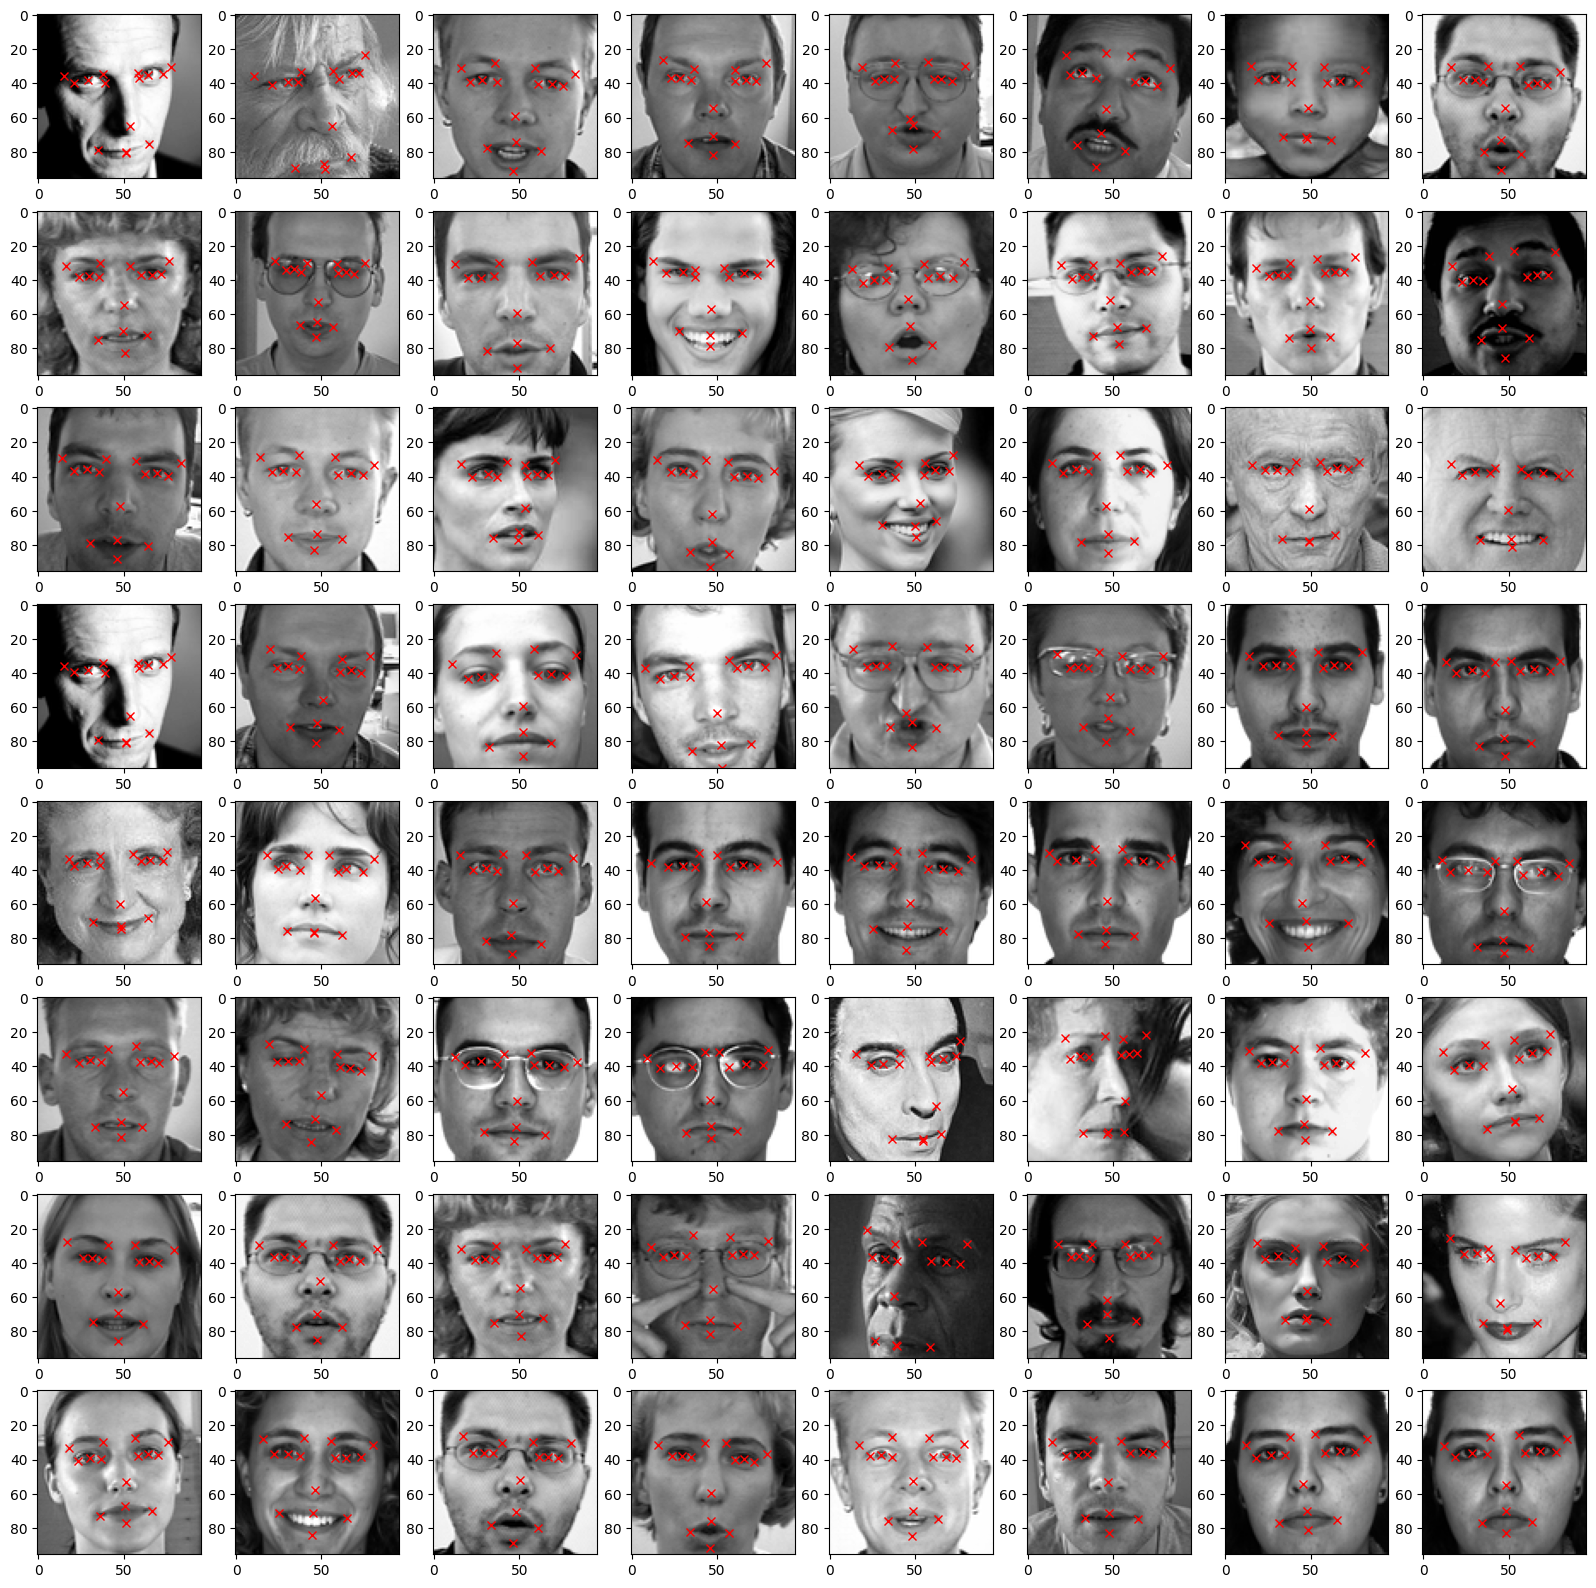

In [13]:
import random

# Let's do a sanity check on random images to ensure the coordinates are accurate. Model is only as good as the data!
fig = plt.figure(figsize=(20, 20))

for i in range(64):
    k = random.randint(1, len(keyfacial_df))
    ax = fig.add_subplot(8, 8, i + 1)    
    image = plt.imshow(keyfacial_df['Image'][k],cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(keyfacial_df.loc[k][j-1], keyfacial_df.loc[k][j], 'rx')

## 6. Perform Image Augmentation

In [14]:
# Create a new copy of the dataframe
import copy
keyfacial_df_copy = copy.copy(keyfacial_df)

In [15]:
# Obtain the columns in the dataframe

columns = keyfacial_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

#### 6.1 Horizontal Flip

In [16]:
# Flip the images along y axis

# Take x values and flip them along y axis.
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))

#Now we have to flip the key facial points coordinates as well

# Since we are flipping horizontally, y coordinate values would be the same
# Only x coordiante values would change
# We have to subtract our initial x-coordinate values from width of the image(96)

for i in range(len(columns)):
  if i%2 == 0:
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

C:\Users\Abdullah\AppData\Local\Temp\ipykernel_27288\622748720.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[0][j-1], keyfacial_df.loc[0][j], 'rx')


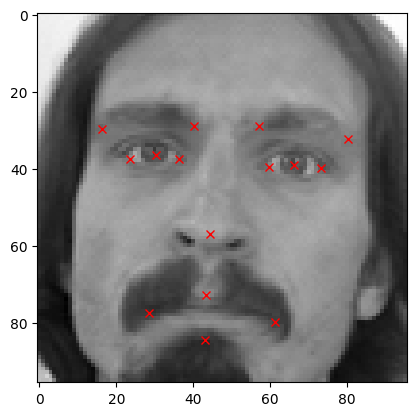

In [17]:
# Show the Original image

plt.imshow(keyfacial_df['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[0][j-1], keyfacial_df.loc[0][j], 'rx')

C:\Users\Abdullah\AppData\Local\Temp\ipykernel_27288\2825411222.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')


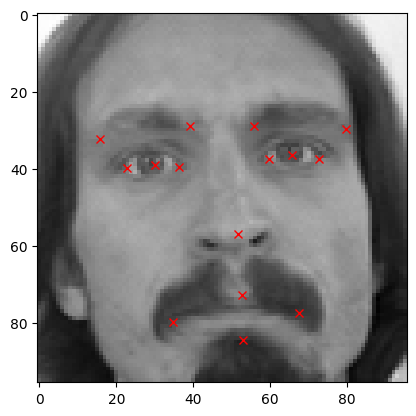

In [18]:
# Show the new augmented Horizontally flipped image

plt.imshow(keyfacial_df_copy['Image'][0],cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

In [19]:
# Concatenate the original dataframe with the augmented dataframe
augmented_df = np.concatenate((keyfacial_df, keyfacial_df_copy))

In [20]:
# Test the size. It should be double.
augmented_df.shape

(4280, 31)

#### 6.2 Increase brightness

In [21]:
import random

keyfacial_df_copy = copy.copy(keyfacial_df)


# We multiply pixel values by random values between 1.5 and 2 to increase the brightness of the image randomly.
# Since the grey scale images have values between 0 and 255, clip them so it doesn't go beyon.
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x:np.clip(random.uniform(1.5, 2)* x, 0.0, 255.0))

# It should add another 2140
augmented_df = np.concatenate((augmented_df, keyfacial_df_copy))
augmented_df.shape

(6420, 31)

C:\Users\Abdullah\AppData\Local\Temp\ipykernel_27288\4183091506.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')


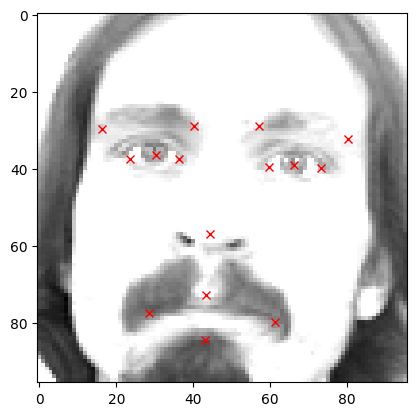

In [22]:
# Show Image with increased brightness

plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

#### 6.3 Vertical Flip

In [23]:
# For the vertical flip, its the same as horizontal flip, but the axis is changed (1 to 0).

keyfacial_df_copy = copy.copy(keyfacial_df)

keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 0))
for i in range(len(columns)):
  # Since the coloums for the y coordinates are odd, change the remainer of 2 to 1 as well.
  if i%2 == 1:
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

C:\Users\Abdullah\AppData\Local\Temp\ipykernel_27288\3675028454.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')


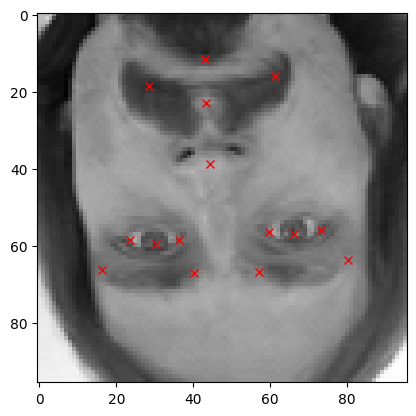

In [24]:
# Perform a sanity check to be sure

plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

In [25]:
augmented_df = np.concatenate((augmented_df, keyfacial_df_copy))

In [26]:
# It should add another 2140
augmented_df.shape

(8560, 31)

## 7. Data normalization

In [27]:
# Obtain the value of images which is present in the 31st column
img = augmented_df[:,30]

# Normalize the images. We can just divide it 255 since it is applicable here.
img = img/255.

# Create an empty array of shape (x, 96, 96, 1) to feed the model
# The model will accept images in batch format so we need to expend it's dimension from (96, 96) to (96, 96, 1)
X = np.empty((len(img), 96, 96, 1))

# Iterate through the img list and add image values to the empty array after it's expansion
for i in range(len(img)):
  X[i,] = np.expand_dims(img[i], axis = 2)

# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(8560, 96, 96, 1)

In [28]:
# Obtain the value of x & y coordinates which are to used as target. This all columns up until not 30th index (31st column)
y = augmented_df[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape

(8560, 30)

## 8. Training data preparation 

In [29]:
# Using scikit learn split 80% of data for training and 20% for testing.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [30]:
X_train.shape

(6848, 96, 96, 1)

In [31]:
X_test.shape

(1712, 96, 96, 1)

## 9. Build Deep ResNet Model 

#### 9.1 Res Block : Conv block -> Identity Block 1 -> Identify Block 2 

In [32]:
def res_block(X, filter, stage):

  X_copy = X

  f1 , f2, f3 = filter


  # Applying convolution (2D) | f1 ,(1,1) represents the size of filter f1
  # Strides (l,r) represent how much shifting to left or right in pixels

  
  # Convolutional Block
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)

  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

    
    
    
    
    
    
  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

    
    
    
    
    
  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

#### 9.2 Final Model

In [33]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128,128,512], stage= 3)

# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)

X = Dense(30, activation = 'relu')(X)

#### 9.3 Model Summary

In [34]:
model_1_facialKeyPoints = tf.keras.Model( inputs= X_input, outputs = X)
model_1_facialKeyPoints.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 48, 48, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1[0][0]']                  
                                                                                              

                                                                                                  
 activation_8 (Activation)      (None, 11, 11, 64)   0           ['bn_2_identity_2_b[0][0]']      
                                                                                                  
 res_2_identity_2_c (Conv2D)    (None, 11, 11, 256)  16640       ['activation_8[0][0]']           
                                                                                                  
 bn_2_identity_2_c (BatchNormal  (None, 11, 11, 256)  1024       ['res_2_identity_2_c[0][0]']     
 ization)                                                                                         
                                                                                                  
 add_2 (Add)                    (None, 11, 11, 256)  0           ['bn_2_identity_2_c[0][0]',      
                                                                  'activation_6[0][0]']           
          

                                                                                                  
 res_3_identity_2_c (Conv2D)    (None, 5, 5, 512)    66048       ['activation_17[0][0]']          
                                                                                                  
 bn_3_identity_2_c (BatchNormal  (None, 5, 5, 512)   2048        ['res_3_identity_2_c[0][0]']     
 ization)                                                                                         
                                                                                                  
 add_5 (Add)                    (None, 5, 5, 512)    0           ['bn_3_identity_2_c[0][0]',      
                                                                  'activation_15[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 5, 5, 512)    0           ['add_5[0][0]']                  
          

## 10. Compile And Train the Model 

#### 10.1 Compile the model

In [115]:
# Refer to Adam optimizer: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.90, beta_2 = 0.999, amsgrad = False)
model_1_facialKeyPoints.compile(loss = "mean_squared_error", optimizer = adam , metrics = ['accuracy'])

#### 10.2 Save the best model

In [116]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = "./Emotion AI Dataset/save/FacialKeyPoints_weights.hdf5", verbose = 1, save_best_only = True)

#### 10.3 Train the model

In [117]:
history = model_1_facialKeyPoints.fit(X_train, y_train, batch_size = 1024, epochs = 50, validation_split = 0.3, callbacks=[checkpointer])

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 5.9809 - accuracy: 0.8623
Epoch 1: val_loss improved from inf to 10.66205, saving model to ./Emotion AI Dataset/save\FacialKeyPoints_weights.hdf5
5/5 [==============================] - 2s 247ms/step - loss: 5.9809 - accuracy: 0.8623 - val_loss: 10.6621 - val_accuracy: 0.8788
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 5.4735 - accuracy: 0.8661
Epoch 2: val_loss improved from 10.66205 to 8.04498, saving model to ./Emotion AI Dataset/save\FacialKeyPoints_weights.hdf5
5/5 [==============================] - 1s 203ms/step - loss: 5.4735 - accuracy: 0.8661 - val_loss: 8.0450 - val_accuracy: 0.8832
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 4.1762 - accuracy: 0.8648
Epoch 3: val_loss did not improve from 8.04498
5/5 [==============================] - 1s 134ms/step - loss: 4.1762 - accuracy: 0.8648 - val_loss: 8.0611 - val_accuracy: 0.8754
Epoch 4/50
5/5 [=============================

Epoch 29/50
5/5 [==============================] - ETA: 0s - loss: 3.1424 - accuracy: 0.8805
Epoch 29: val_loss did not improve from 7.58346
5/5 [==============================] - 1s 144ms/step - loss: 3.1424 - accuracy: 0.8805 - val_loss: 7.8183 - val_accuracy: 0.8803
Epoch 30/50
5/5 [==============================] - ETA: 0s - loss: 3.1328 - accuracy: 0.8767
Epoch 30: val_loss did not improve from 7.58346
5/5 [==============================] - 1s 145ms/step - loss: 3.1328 - accuracy: 0.8767 - val_loss: 7.7028 - val_accuracy: 0.8783
Epoch 31/50
5/5 [==============================] - ETA: 0s - loss: 3.0869 - accuracy: 0.8729
Epoch 31: val_loss did not improve from 7.58346
5/5 [==============================] - 1s 145ms/step - loss: 3.0869 - accuracy: 0.8729 - val_loss: 7.6385 - val_accuracy: 0.8842
Epoch 32/50
5/5 [==============================] - ETA: 0s - loss: 3.0978 - accuracy: 0.8830
Epoch 32: val_loss improved from 7.58346 to 7.51105, saving model to ./Emotion AI Dataset/save\Fa

#### 10.4 Save the actual architecture of the model

In [118]:
model_json = model_1_facialKeyPoints.to_json()
with open("./Emotion AI Dataset/save/FacialKeyPoints-model.json","w") as json_file:
  json_file.write(model_json)

## 11. Test the model performance

#### 11.1 Load the model architecture

In [119]:
with open('./Emotion AI Dataset/save/FacialKeyPoints-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
model_1_facialKeyPoints = tf.keras.models.model_from_json(json_savedModel)
model_1_facialKeyPoints.load_weights('./Emotion AI Dataset/save/FacialKeyPoints_weights.hdf5')
model_1_facialKeyPoints.compile(loss="mean_squared_error", optimizer= adam , metrics = ['accuracy'])

#### 11.2 Evaluate the model

In [120]:
result = model_1_facialKeyPoints.evaluate(X_test, y_test)
print("Accuracy : {}".format(result[1]))

54/54 [==============================] - 0s 3ms/step - loss: 8.2892 - accuracy: 0.8820
Accuracy : 0.8820093274116516


In [121]:
# Get the model keys 
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

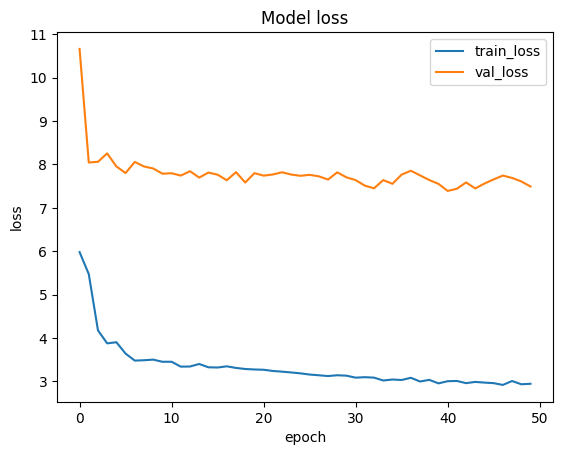

In [122]:
# Plot the training artifacts

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()